In [1]:
# import needed libraries
import numpy as np
import string
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')
import email
import re
from datetime import datetime
from dateutil import tz
import networkx as nx
import nltk
import wordcloud
import plotly.express as px
from plotly import graph_objects as go

# Machine learning and NLP libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn import metrics
import scipy as sp
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer



/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
pip install vadersentiment

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 3.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install NRCLex

INFO: pip is looking at multiple versions of nrclex to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 396.4/396.4 kB 7.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ done
  Created wheel for NRCLex: filename=NRCLex-3.0.0-py3-none-any.whl size=43331 sha256=fea6d3c55fda2a03fc4d32806f057adbce639a46e07105c748b181ca5acce709
  Stored in directory: /root/.cache/pip/wheels/d2/10/44/6abfb1234298806a145fd6bcaec8cbc712e88dd1cd6cb242fa
Successfully built NRCLex
Note: you may need to restart the kernel to use updated packages.


In [4]:
# Sentiment Analysis
import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nrclex import NRCLex

**Loading the data**

In [5]:
df = pd.read_csv(r"/kaggle/input/enron-email-dataset/emails.csv")

In [6]:
df.head()

file                                            message
0     allen-p/_sent_mail/1.  Message-ID: <18782981.1075855378110.JavaMail.e...
1    allen-p/_sent_mail/10.  Message-ID: <15464986.1075855378456.JavaMail.e...
2   allen-p/_sent_mail/100.  Message-ID: <24216240.1075855687451.JavaMail.e...
3  allen-p/_sent_mail/1000.  Message-ID: <13505866.1075863688222.JavaMail.e...
4  allen-p/_sent_mail/1001.  Message-ID: <30922949.1075863688243.JavaMail.e...

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517401 entries, 0 to 517400
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   file     517401 non-null  object
 1   message  517401 non-null  object
dtypes: object(2)
memory usage: 7.9+ MB


**Data cleaning and preparing**

In [8]:
# Write functions to extract mail headers and body
def extractmailitems(field, msg):
    elst = []
    
    for i, message in (msg.items()):
        e = email.message_from_string(message)
        elst.append(e.get(field))
       
    return elst


In [9]:
columns = ['Date', 'From', 'To', 'Subject', 'X-From', 'X-To', 'X-Folder', 'X-Origin', 'X-Filename']
for i in columns:
    df[i] = extractmailitems(i, df['message'])

In [10]:
def body(col):
    bodycolumn = []
    for message in col.values:
        e = email.message_from_string(message)
        bodycolumn.append(e.get_payload())
 
    return bodycolumn
df['Body'] = body(df['message'])

In [11]:
# extract emplyees' names from file column
def employees(files):
    employees = []
    for i, employee in files.items():
        employee = employee.split('/')[0]
        employees.append(employee)
    return employees
df['Employee'] = employees(df['file'])

In [12]:
df.sample(5)

file  \
428663          shackleton-s/sent/5159.   
4601        arnold-j/all_documents/728.   
76621      dasovich-j/notes_inbox/5166.   
9987             bass-e/_sent_mail/104.   
315029  mann-k/discussion_threads/4851.   

                                                  message  \
428663  Message-ID: <17483633.1075844900129.JavaMail.e...   
4601    Message-ID: <25338545.1075857606730.JavaMail.e...   
76621   Message-ID: <28073728.1075843728024.JavaMail.e...   
9987    Message-ID: <14743104.1075854709181.JavaMail.e...   
315029  Message-ID: <33147432.1075845874505.JavaMail.e...   

                                         Date                   From  \
428663  Mon, 18 Dec 2000 08:06:00 -0800 (PST)   kaye.ellis@enron.com   
4601    Tue, 17 Apr 2001 14:03:00 -0700 (PDT)  john.arnold@enron.com   
76621   Wed, 28 Feb 2001 00:32:00 -0800 (PST)    lisa.yoho@enron.com   
9987     Wed, 6 Dec 2000 07:31:00 -0800 (PST)    eric.bass@enron.com   
315029   Wed, 6 Jun 2001 05:07:00 -0700 (PDT)  greg.krause@enron.com   

                                                       To  \
428663  ryan.siurek@enron.com, clint.freeland@enron.co...   
4601                            jennifer.fraser@enron.com   
76621                             jeff.dasovich@enron.com   
9987                              patrick.ryder@enron.com   
315029                                 kay.mann@enron.com   

                                  Subject       X-From  \
428663                      Enron Forward   Kaye Ellis   
4601                 RE: ng views + wager  John Arnold   
76621                             SoCalEd    Lisa Yoho   
9987                         Re: Pick ups    Eric Bass   
315029  RE: Midway Interconnect Agreement  Greg Krause   

                                                     X-To  \
428663  Ryan Siurek, Clint Freeland, Jeff Nogid, Jim A...   
4601                                      Jennifer Fraser   
76621                                       Jeff Dasovich   
9987                                        Patrick Ryder   
315029                                           Kay Mann   

                                                 X-Folder      X-Origin  \
428663  \Sara_Shackleton_Dec2000_June2001_2\Notes Fold...  SHACKLETON-S   
4601     \John_Arnold_Jun2001\Notes Folders\All documents      Arnold-J   
76621   \Jeff_Dasovich_June2001\Notes Folders\Notes inbox    DASOVICH-J   
9987          \Eric_Bass_Dec2000\Notes Folders\'sent mail        Bass-E   
315029  \Kay_Mann_June2001_2\Notes Folders\Discussion ...        MANN-K   

          X-Filename                                               Body  \
428663  sshackle.nsf  Attached is the document comparing the Sample ...   
4601     Jarnold.nsf  7:2 at 2:1\n\n\nFrom: Jennifer Fraser/ENRON@en...   
76621   jdasovic.nsf  Jeff -- \n\nI got a question yesterday from th...   
9987       ebass.nsf  You cannot pickup players in the playoffs.  Th...   
315029     kmann.nsf  Kay,\n\nA&K did the title committment work and...   

            Employee  
428663  shackleton-s  
4601        arnold-j  
76621     dasovich-j  
9987          bass-e  
315029        mann-k

In [13]:
# drop unimportant data columns and empty cells
df.drop(columns = ['file', 'message'], inplace=True)
df.dropna(axis = 0, inplace=True)
df.sample(5)

Date                      From  \
441101   Mon, 7 May 2001 03:02:10 -0700 (PDT)             alex@pira.com   
511154  Mon, 21 Jan 2002 13:56:31 -0800 (PST)      pete.davis@enron.com   
478515  Mon, 28 Aug 2000 10:01:00 -0700 (PDT)    anne.koehler@enron.com   
468684   Wed, 7 Mar 2001 00:13:00 -0800 (PST)    david.poston@enron.com   
382570   Thu, 8 Jun 2000 08:19:00 -0700 (PDT)  kevin.ruscitti@enron.com   

                                                       To  \
441101                                      alex@pira.com   
511154                               pete.davis@enron.com   
478515  froebam@moodys.com, david.howard@fitchratings....   
468684  alan.comnes@enron.com, alan.larsen@enron.com, ...   
382570                            jim.armsworth@enron.com   

                                                  Subject  \
441101  PIRA's Electricity Daily Demand Forecast 05/07/01   
511154                Schedule Crawler: HourAhead Failure   
478515  Letter regarding calculation of OC Ratios for ...   
468684                         Enpower Deal Entry Changes   
382570                                      Re: New House   

                                                   X-From  \
441101  "Alex Golubov" <alex@pira.com>@ENRON <IMCEANOT...   
511154  Davis, Pete </O=ENRON/OU=NA/CN=RECIPIENTS/CN=P...   
478515                                     Anne C Koehler   
468684                                       David Poston   
382570                                     Kevin Ruscitti   

                                                     X-To  \
441101  PIRA Electricity Daily Demand Client <alex@pir...   
511154  Davis, Pete </O=ENRON/OU=NA/CN=RECIPIENTS/CN=P...   
478515  froebam@moodys.com, david.howard@fitchratings....   
468684  Alan Comnes, Alan Larsen, Amy FitzPatrick, And...   
382570                                      Jim Armsworth   

                                                 X-Folder     X-Origin  \
441101  \Shively, Hunter S.\Shively, Hunter S.\Deleted...    SHIVELY-H   
511154     \ExMerge - Williams III, Bill\Schedule Crawler  WILLIAMS-W3   
478515    \Mark_Taylor_Jun2001\Notes Folders\Archive\8_00     Taylor-M   
468684  \kate symes 6-27-02\Notes Folders\Discussion t...      SYMES-K   
382570   \Kevin_Ruscitti_Dec2000\Notes Folders\'sent mail   Ruscitti-K   

                    X-Filename  \
441101  Shively, Hunter S..pst   
511154                           
478515             mtaylor.nsf   
468684  kate symes 6-27-02.nsf   
382570             kruscit.nsf   

                                                     Body     Employee  
441101  Attached is PIRA's latest "Electricity Daily D...    shively-h  
511154  \n\nStart Date: 1/21/02; HourAhead hour: 12;  ...  williams-w3  
478515  Attached hereto is the form of letter confirmi...     taylor-m  
468684  Good Morning,\n\nWe will be rolling out a new ...      symes-k  
382570  Good to hear from you.  The name of the jewele...   ruscitti-k

In [14]:
df.Employee.value_counts()[:20]

kaminski-v      27801
dasovich-j      27463
kean-s          23896
mann-k          23302
jones-t         19739
shackleton-s    18371
taylor-m        13371
farmer-d        12862
germany-c       12267
beck-s          11555
nemec-g         10467
symes-k         10332
scott-s          7788
rogers-b         7760
bass-e           7638
sanders-r        7096
campbell-l       6085
guzman-m         6030
shapiro-r        5872
lenhart-m        5832
Name: Employee, dtype: int64

In [15]:
# changing the date format and type from string to date object
df['Date'] = pd.to_datetime(df['Date'], utc = True, dayfirst = True)

In [16]:
# creating a year column from the date column
df['Year'] = pd.DatetimeIndex(df['Date']).year

In [17]:
df.Year.value_counts()

2001    256402
2000    192904
2002     34782
1999     10896
1980       316
1998       166
2004        70
2044         3
2020         2
1986         2
2007         1
2005         1
1997         1
2043         1
Name: Year, dtype: int64

In [18]:
# a function for cleaning text in columns

def extract(col):
    regcol = []
    for sent in col.values:
        
        if str(sent).startswith('<'):  
            reg = re.split(r'@|\(', str(sent))[0]
            reg = re.findall(r'[a-zA-Z]+\'?-?', str(reg))           
            
        elif re.match(r'^\d+', str(sent)):
            reg = re.split(r'@|\(', str(sent))[0]
            reg = re.findall(r'[0-9]+\'?-?', str(reg))
           
        else:
            reg = re.split(r'@|<|\(', str(sent))[0]
            reg = re.findall(r'[a-zA-Z]+\'?-?', str(reg))
            
        reg = re.sub(r'[\'\",]', '', str(reg))
        regcol.append(str(reg.strip('[]')))
           
            
    return regcol

In [19]:
df['X-From'] = extract(df['X-From'])
df['X-To'] = extract(df['X-To'])

In [20]:
df['X-From'].value_counts()[:20]

Kay Mann               16314
Vince J Kaminski       14329
Jeff Dasovich           9715
Enron Announcements     8577
Tana Jones              8065
Sara Shackleton         7950
Chris Germany           7298
Steven J Kean           6211
Schedule Crawler        6179
Kate Symes              5223
Eric Bass               4861
Matthew Lenhart         4712
Sally Beck              3868
Debra Perlingiere       3647
Drew Fossum             3622
Carol St Clair          3544
Benjamin Rogers         3311
Gerald Nemec            3244
Richard B Sanders       3209
Phillip M Love          3107
Name: X-From, dtype: int64

In [21]:
df['X-To'].value_counts()[:20]

pete davis             5337
vkaminski              4749
Tana Jones             4587
Davis Pete             3821
Jeff Dasovich          3669
Sara Shackleton        3378
All Enron Worldwide    3324
Vince J Kaminski       3321
Kate Symes             3211
Steven J Kean          3086
Mark Taylor            2732
Kay Mann               2380
Daren J Farmer         2292
Kitchen Louise         2208
Gerald Nemec           1986
All Enron Houston      1956
Sally Beck             1912
Suzanne Adams          1786
klay                   1533
Benjamin Rogers        1369
Name: X-To, dtype: int64

In [22]:
df.sample(5)

Date                         From  \
308639 2001-05-11 10:41:00+00:00           kay.mann@enron.com   
181428 2001-06-05 19:53:00+00:00   arsystem@mailman.enron.com   
434886 2001-03-29 11:06:00+00:00  daniel.allegretti@enron.com   
508082 2001-05-24 17:32:38+00:00             rrdvl@hotbot.com   
28435  2000-11-16 16:29:00+00:00   arsystem@mailman.enron.com   

                                                       To  \
308639                           rebecca.walker@enron.com   
181428                               tana.jones@enron.com   
434886  richard.shapiro@enron.com, joe.hartsoe@enron.c...   
508082                                      mekoq@aol.com   
28435                                sally.beck@enron.com   

                                                  Subject             X-From  \
308639                         Re: Blue Dog Meeting Today           Kay Mann   
181428  Request Closed: Access Request for donna.lowry...           ARSystem   
434886                    Standard Market Design Proposal  Daniel Allegretti   
508082  COMPANIES IN PLAY...\n                        ...              rrdvl   
28435   Request Submitted: Access Request sally.beck@e...           ARSystem   

                                                     X-To  \
308639                                     Rebecca Walker   
181428                                         tana jones   
434886  Richard Shapiro Joe Hartsoe Sarah Novosel Chri...   
508082                                              mekoq   
28435                                          sally beck   

                                                 X-Folder    X-Origin  \
308639   \Kay_Mann_June2001_1\Notes Folders\All documents      MANN-K   
181428  \Tanya_Jones_June2001\Notes Folders\All documents     JONES-T   
434886  \Richard_Shapiro_June2001\Notes Folders\All do...   SHAPIRO-R   
508082  \Williams, Jason (Trading)\Williams, Jason (Tr...  WILLIAMS-J   
28435        \Sally_Beck_Dec2000\Notes Folders\Eol access      Beck-S   

                           X-Filename  \
308639                      kmann.nsf   
181428                     tjones.nsf   
434886                   rshapiro.nsf   
508082  Williams, Jason (Trading).pst   
28435                       sbeck.nsf   

                                                     Body    Employee  Year  
308639  How about 100?\n\n\n   \n\t\n\t\n\tFrom:  Rebe...      mann-k  2001  
181428  The request has been completed with all resour...     jones-t  2001  
434886  ---------------------- Forwarded by Daniel All...   shapiro-r  2001  
508082  COMPANIES IN PLAY\nMay 23, 2001\n\nNETSOL INTE...  williams-j  2001  
28435   Thank you for your request. You will be notifi...      beck-s  2000

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 495547 entries, 0 to 517400
Data columns (total 12 columns):
 #   Column      Non-Null Count   Dtype              
---  ------      --------------   -----              
 0   Date        495547 non-null  datetime64[ns, UTC]
 1   From        495547 non-null  object             
 2   To          495547 non-null  object             
 3   Subject     495547 non-null  object             
 4   X-From      495547 non-null  object             
 5   X-To        495547 non-null  object             
 6   X-Folder    495547 non-null  object             
 7   X-Origin    495547 non-null  object             
 8   X-Filename  495547 non-null  object             
 9   Body        495547 non-null  object             
 10  Employee    495547 non-null  object             
 11  Year        495547 non-null  int64              
dtypes: datetime64[ns, UTC](1), int64(1), object(10)
memory usage: 49.1+ MB


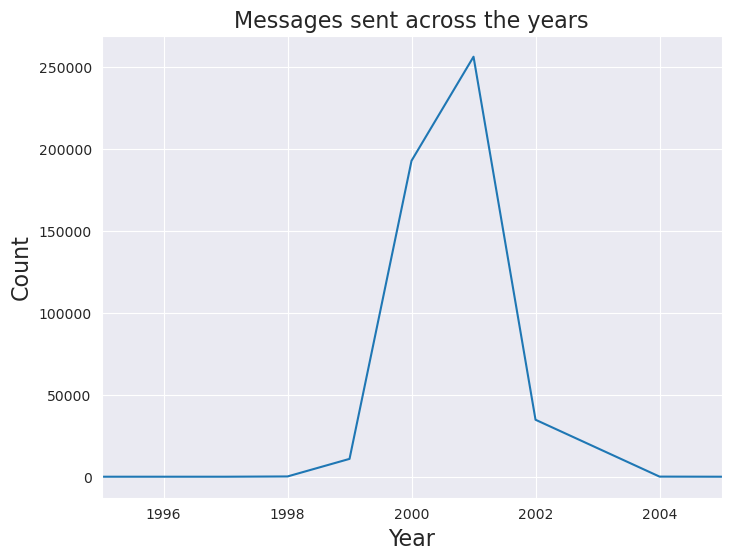

In [24]:
# make a diagram to show the count of messages sent per year
ax = df.groupby(df.Year)['X-Origin'].count().plot(figsize = (8,6))
ax.set_xlim(1995,2005)
ax.set_xlabel('Year', fontsize = 16)
ax.set_ylabel('Count', fontsize = 16)
ax.set_title('Messages sent across the years', fontsize = 16)
plt.show()

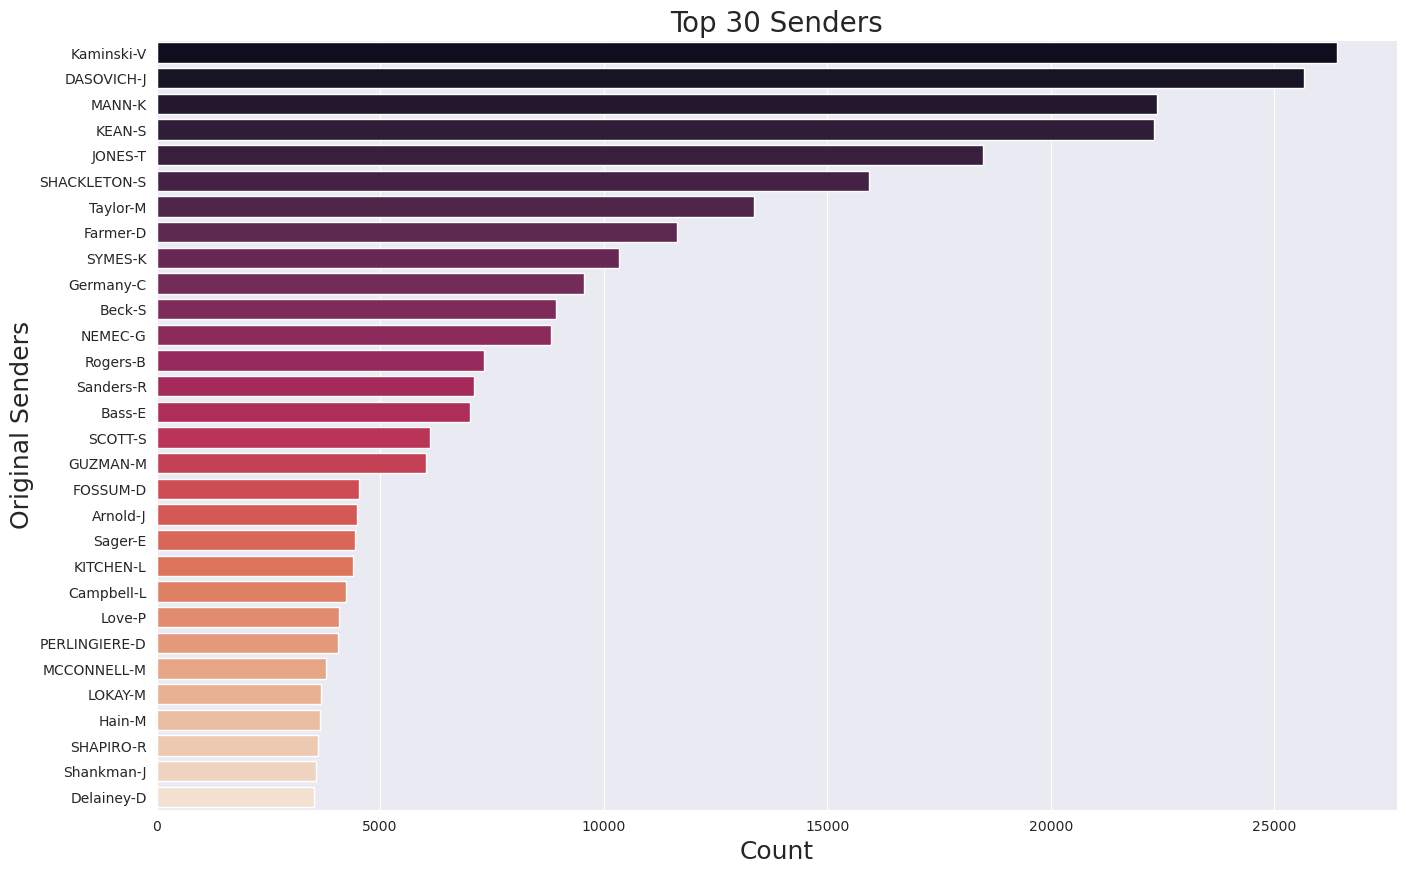

In [25]:
# diagram for showing top senders
plt.figure(figsize = (16,10))
ax = sns.barplot(x = df['X-Origin'].value_counts().values[:30], y = df['X-Origin'].value_counts().keys()[:30] ,palette = 'rocket', orient = 'h')
ax.set_xlabel('Count', fontsize = 18)
ax.set_ylabel('Original Senders', fontsize = 18)
ax.set_title('Top 30 Senders', fontsize = 20)
plt.show()

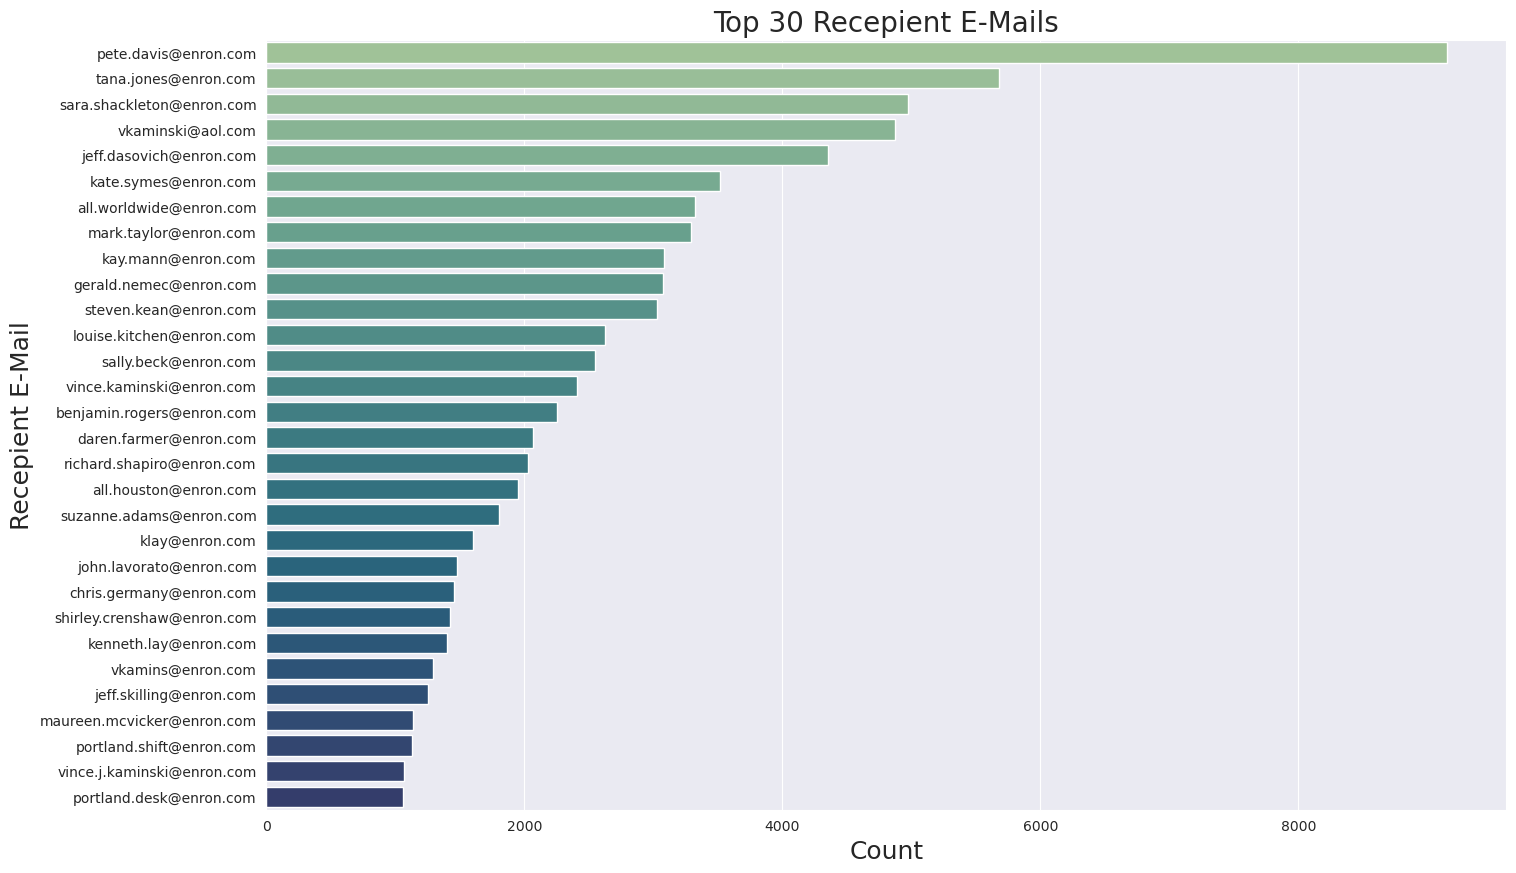

In [26]:
# diagram showing top recepients
plt.figure(figsize = (16,10))
ax = sns.barplot(x = df['To'].value_counts().values[:30], y = df['To'].value_counts().keys()[:30] ,palette = 'crest', orient = 'h')
ax.set_xlabel('Count', fontsize = 18)
ax.set_ylabel('Recepient E-Mail', fontsize = 18)
ax.set_title('Top 30 Recepient E-Mails', fontsize = 20)
plt.show()

In [27]:
userlist = df['X-Origin'].unique()

In [28]:
useryears = []
for user in userlist:
    year = df.loc[df['X-Origin'] == user, 'Year'].iloc[0]
    useryears.append(year)
    useryears


In [29]:
usercount = []
counter = 0
for name in userlist:
    for user in df['X-Origin'].values:
        if user == name:
            counter += 1
    usercount.append(counter)
    counter = 0


In [30]:
dataf = sorted(list(zip(userlist, usercount, useryears)), key= lambda user: user[1], reverse = True)[:30]

In [31]:
dataf = pd.DataFrame(dataf)
dataf.columns = ['User', 'Count', 'Year']
dataf.head()

User  Count  Year
0  Kaminski-V  26409  2001
1  DASOVICH-J  25656  2000
2      MANN-K  22372  2001
3      KEAN-S  22296  2000
4     JONES-T  18475  1999

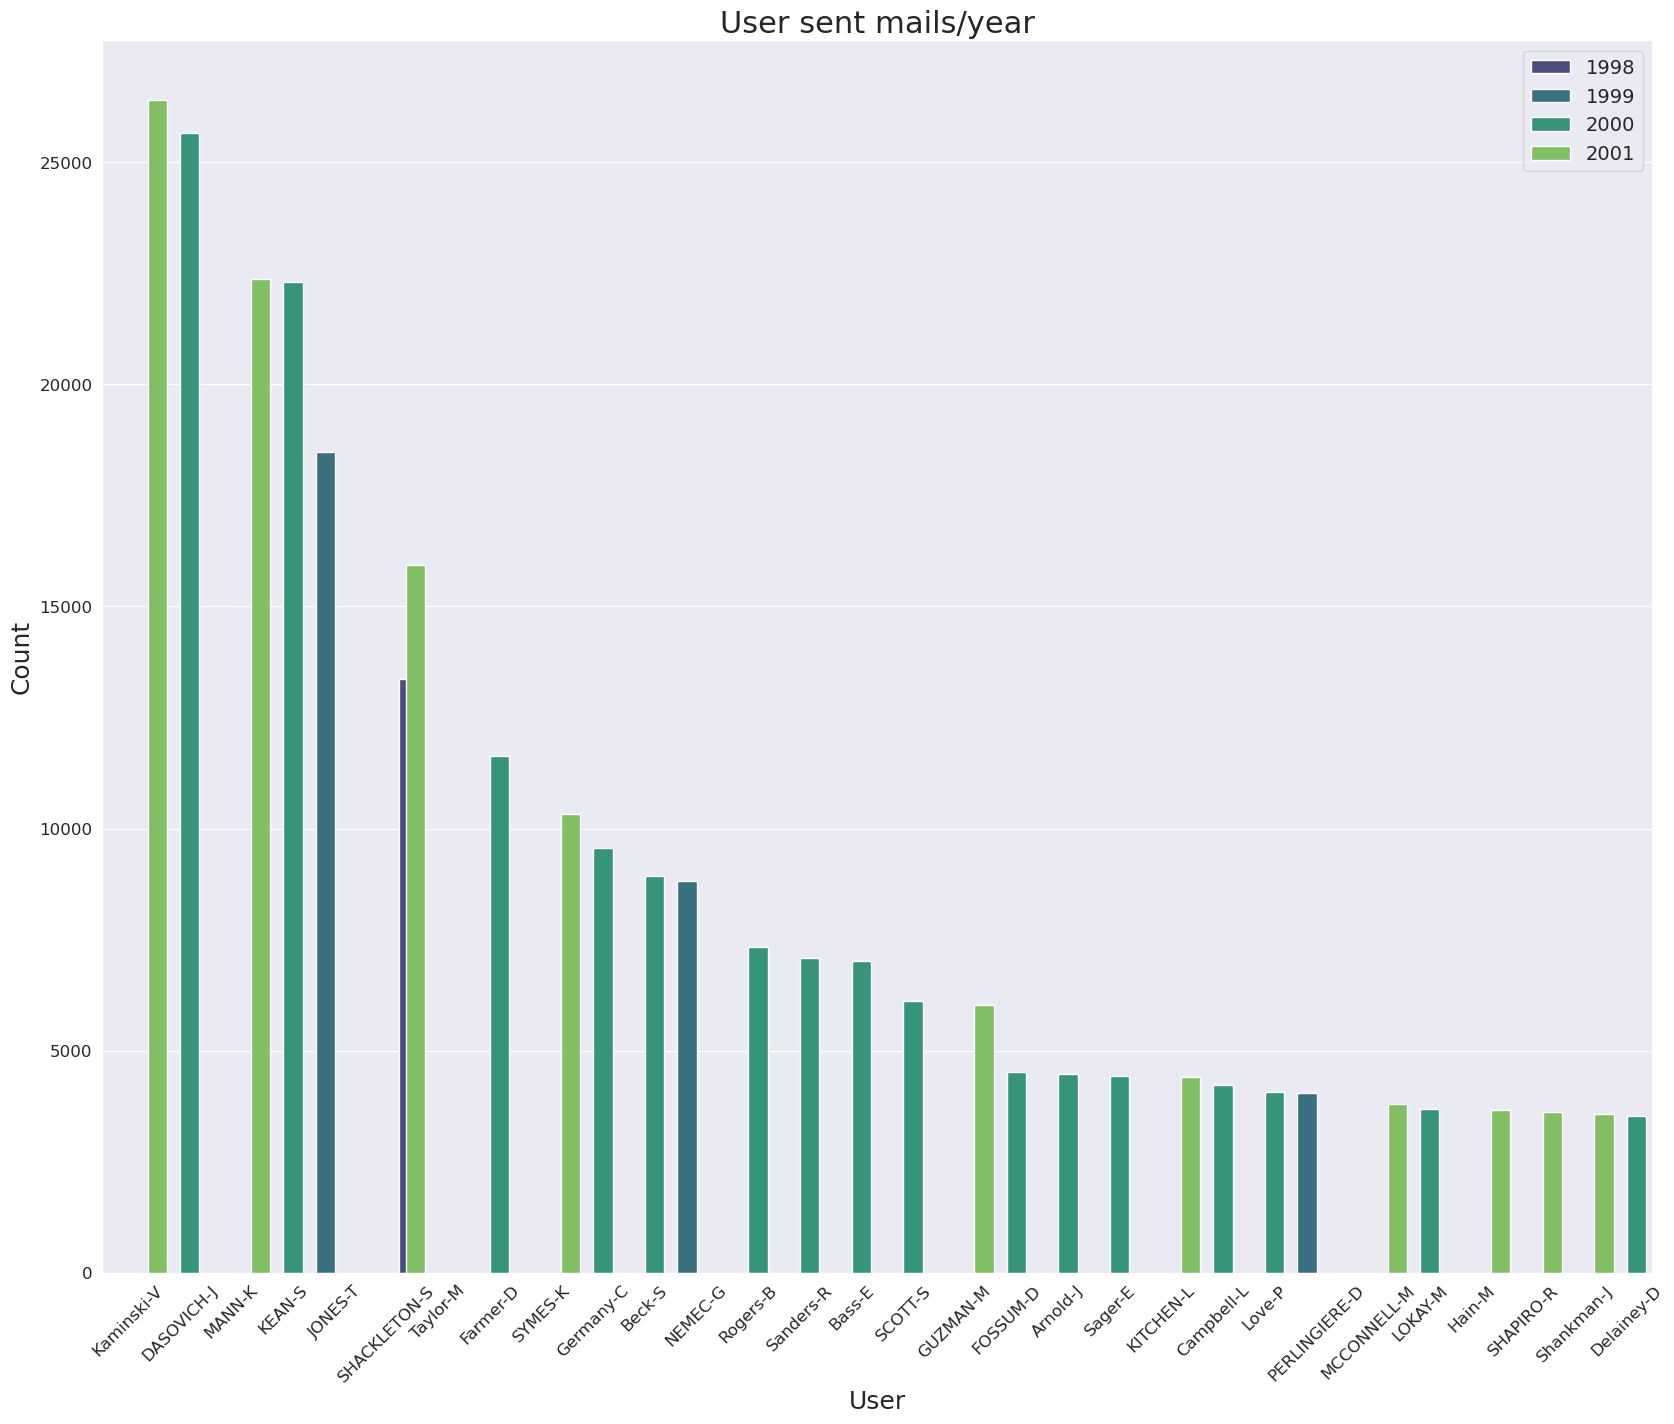

In [32]:
# diagram showing top users and count of mails sent per year
plt.figure(figsize = (20,16))
ax = sns.barplot(data = dataf, x ='User', y = 'Count', hue = 'Year', palette = 'viridis' , saturation = 0.7, width = 1.5)
sns.despine()
plt.xlabel('User', fontsize = 18)
plt.ylabel('Count', fontsize = 18)
plt.title('User sent mails/year', fontsize = 22)
plt.xticks(rotation = 45, fontsize = 12)
plt.yticks(fontsize = 12)
plt.legend(fontsize = 14)
plt.show()

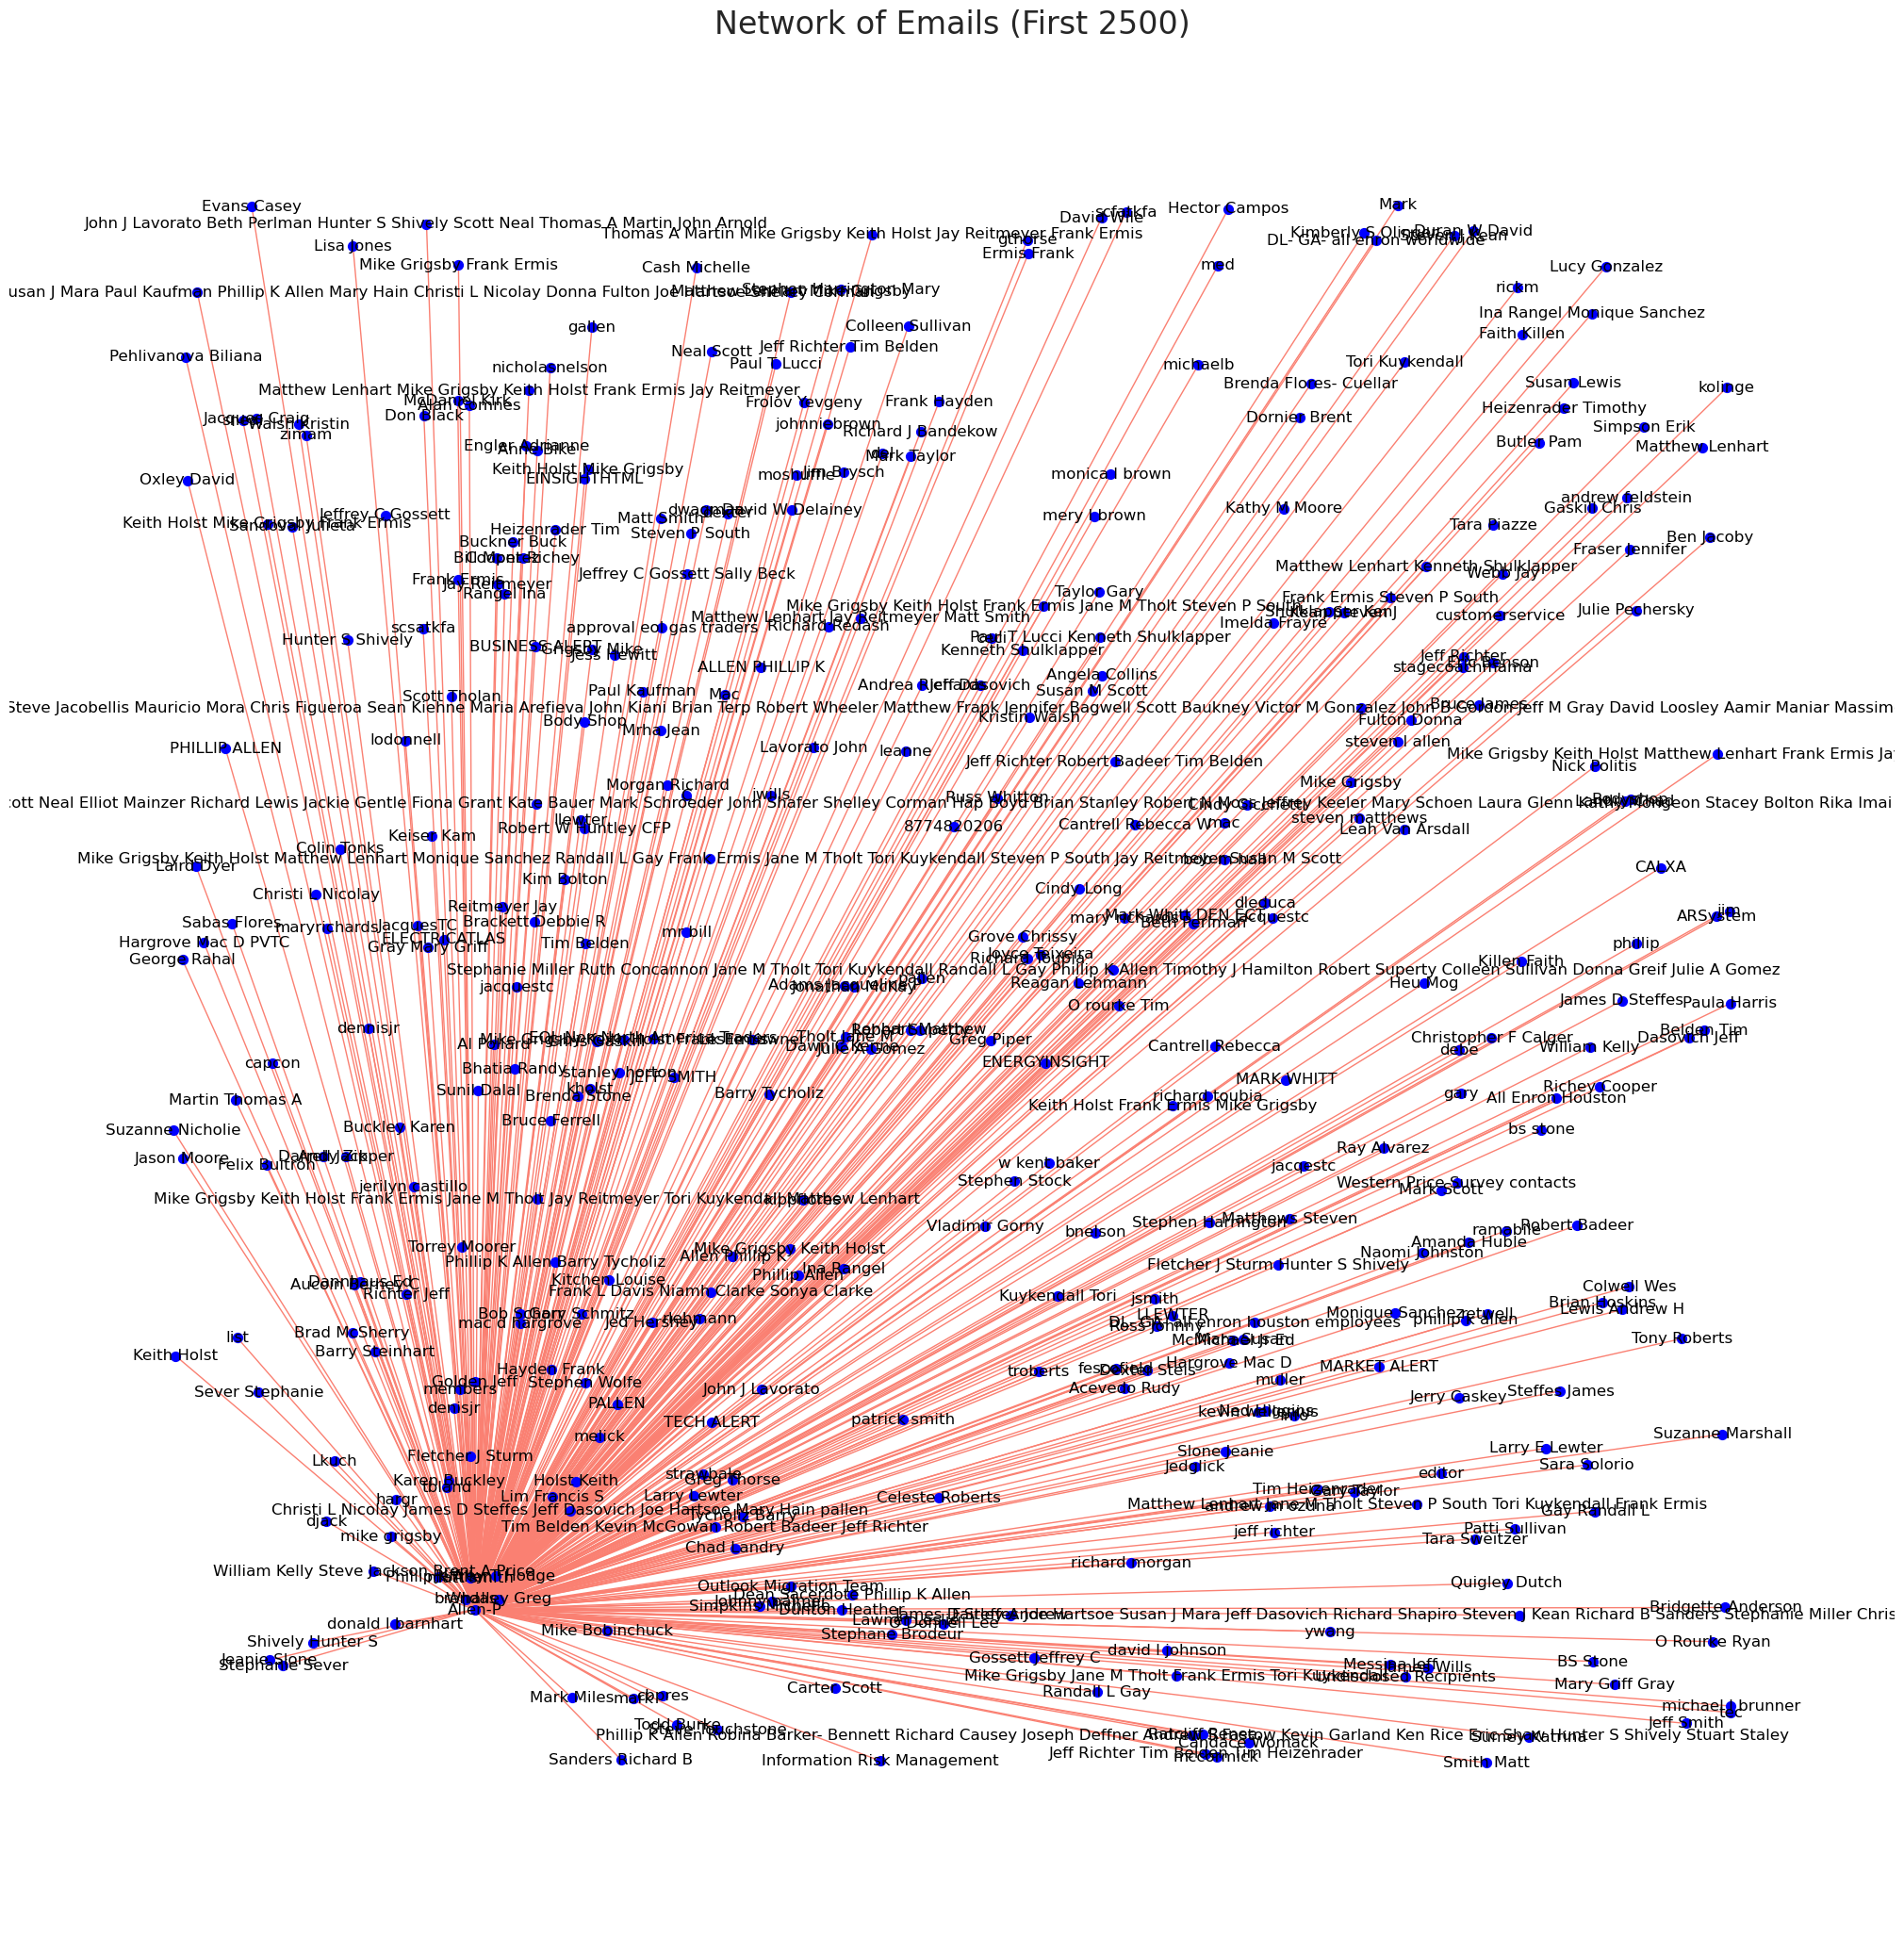

In [33]:
# a network of first 2500 rows showing the network of Allen P
plt.figure(figsize = (20, 20))
G = nx.from_pandas_edgelist(df[:2500], 'X-Origin', 'X-To')
pos = nx.draw_random(G, node_size = 50, node_color = 'blue', edge_color = 'salmon', with_labels = True)
plt.title('Network of Emails (First 2500)', fontsize = 24)
plt.show()

**Machine Learning and NLP on the dataset**

In [34]:
stopwords = nltk.corpus.stopwords.words('english')
newstopwords = ['Re', 'FW', 'Fwd', 'EOL', 'E', 'mail', 'PLEASE', 'Ahead']
for i in newstopwords:
    stopwords.append(i)


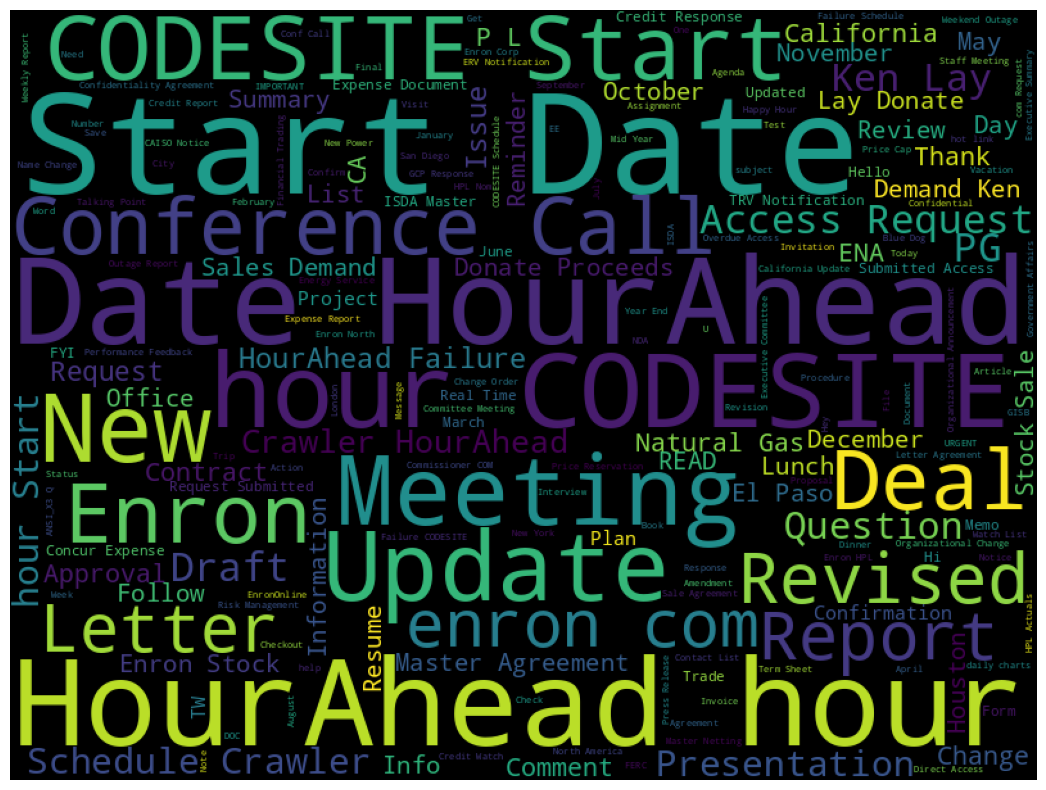

In [35]:
subjects = ' '.join(df['Subject'].values)
fig, ax = plt.subplots(figsize=(14, 10))
wc = wordcloud.WordCloud(width = 800, height = 600, max_words = 200, stopwords = stopwords).generate(subjects)
ax.imshow(wc)
plt.axis('off')
plt.show()

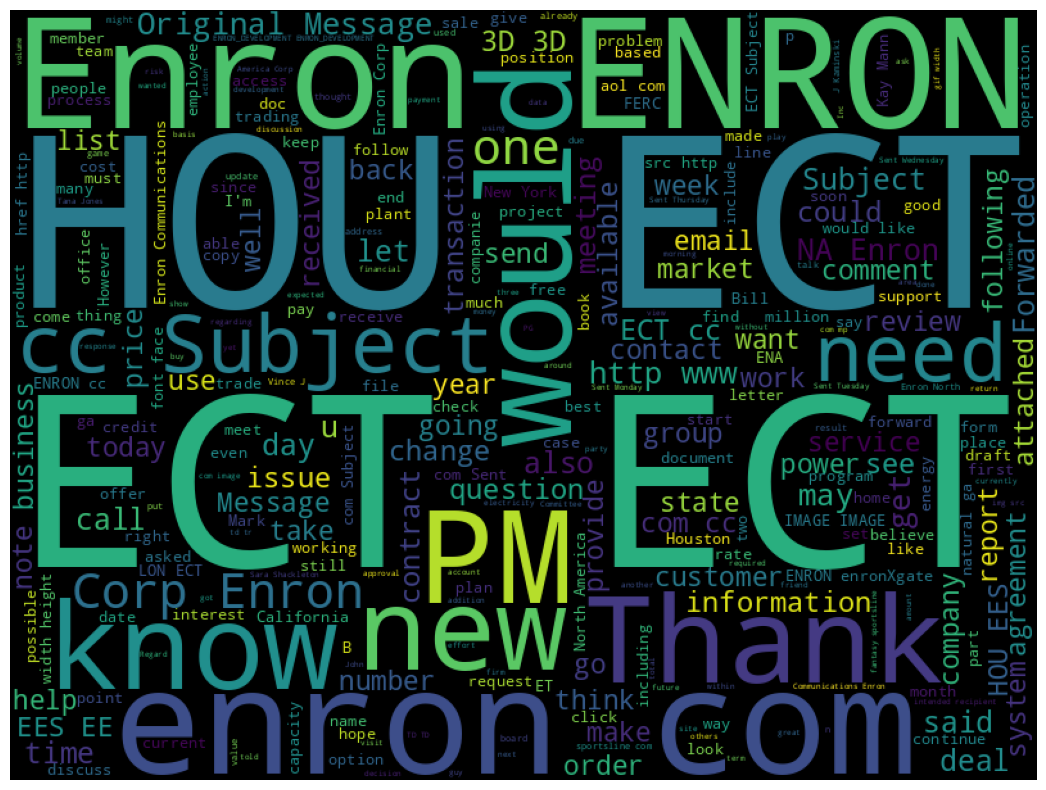

In [36]:
content = ' '.join(df['Body'].sample(5000).values)
fig, ax = plt.subplots(figsize=(14, 10))
wc = wordcloud.WordCloud(width = 800, height = 600, max_words = 300, stopwords = stopwords).generate(content)
ax.imshow(wc)
plt.axis('off')
plt.show()

In [37]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [38]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [39]:
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

In [40]:
# function for cleaning the body text
def cleaningbody(col):
    msgcol = []
    for msg in col.values:
        msg = re.sub(r'[<>\n+\t+\s+\*]', ' ', msg)
        msg = re.sub(r'[0-9]+[a-zA-Z]+\d+[?!].DOC', ' ', msg)
        msg = re.sub(r'[?\s+\-+\s+?_=~]', ' ', msg)
        msg = re.sub(r' +', ' ', msg)
        msg = msg.lower().strip(' ')
        msgcol.append(msg)
    return msgcol
df['Body'] = cleaningbody(df['Body'])

In [41]:
# preparing the lemmatization function
lemmatizer = WordNetLemmatizer()

In [42]:
# Tokenizing and lemmatizing the text to prepare for classification and sentiment analysis
text = []
for msg in df['Body'].values:
    msg_tokens = word_tokenize(msg)
    msg_tokens = [token.lower() for token in msg_tokens if token.isalpha()]
    msg_tokens = [word for word in msg_tokens if not word in stopwords]
    msg_tokens = [lemmatizer.lemmatize(word) for word in msg_tokens]
    
    text.append(msg_tokens)


In [43]:
text = [' '.join(message) for message in text]

In [44]:
# vectorizing the data using Tfidfvectorizer
vectorizer = TfidfVectorizer(min_df = 5, max_features = 5000, stop_words = stopwords, norm = 'l1')
data = vectorizer.fit_transform(text)


/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ahead', 'eol', 'fw', 'fwd', 'please'] not in stop_words.
  warnings.warn(


In [45]:
# Normalizing the data
data_norm = normalize(data)

In [46]:
print(data_norm.shape)

(495547, 5000)


In [47]:
# Decomposition of the data and decreasing alot of features
svd = TruncatedSVD(n_components = 2, n_iter = 10, random_state = 42)
datasvd = svd.fit_transform(data_norm)

In [48]:
datasvd.shape

(495547, 2)

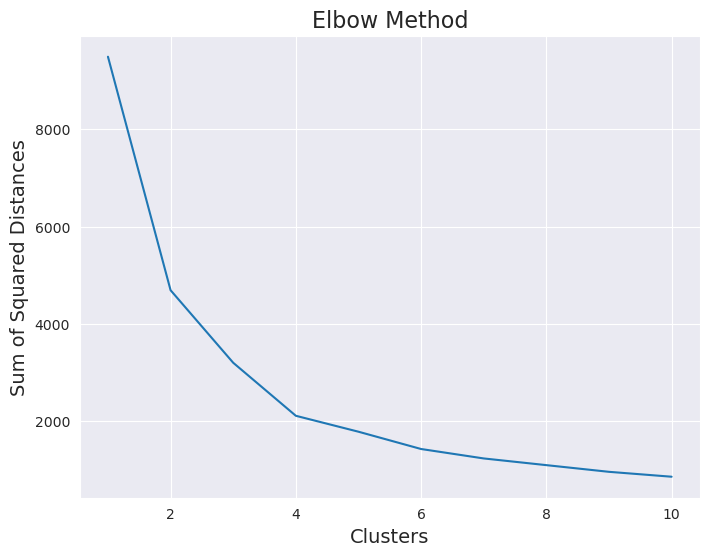

In [49]:
# Use the Elbow method to define the optimal number of clusters for kmeans clustering
max_iter = 1000
sumsquares = []
number_clusters = range(1,11)
for i in number_clusters:
    kmeans = KMeans(n_clusters = i, max_iter = max_iter, n_init = 'auto')
    kmeans.fit(datasvd)
    sumsquares.append(kmeans.inertia_)
plt.figure(figsize = (8,6))
plt.plot(number_clusters, sumsquares)
plt.xlabel('Clusters', fontsize = 14)
plt.ylabel('Sum of Squared Distances', fontsize = 14)
plt.title('Elbow Method', fontsize = 16)
plt.show()

In [50]:
n_clusters = 6
clf = KMeans(n_clusters = n_clusters,init = 'random', max_iter = max_iter, tol = 0.0001, algorithm = 'lloyd', n_init = 'auto', random_state = 42)
fittedkmeans = clf.fit_predict(datasvd)
centroids = clf.cluster_centers_

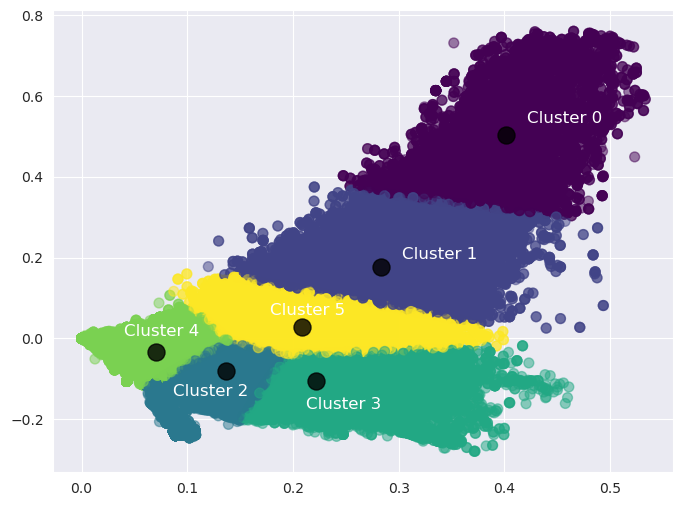

In [51]:
# A diagram showing the clusters
plt.figure(figsize = (8,6))
plt.scatter(datasvd[:,0], datasvd[:,1], c = fittedkmeans, s = 50, cmap = 'viridis', alpha = 0.5)
plt.scatter(centroids[:, 0], centroids[:, 1], s = 150, c = 'black', alpha = 0.8)
plt.annotate('Cluster 0', xy = (centroids[0][0], centroids[0][1]), xytext = (centroids[0][0] + 0.02, centroids[0][1] + 0.03), color = 'white', fontsize = 12)
plt.annotate('Cluster 1', xy = (centroids[1][0], centroids[1][1]), xytext = (centroids[1][0] + 0.02, centroids[1][1] + 0.02), color = 'white', fontsize = 12)
plt.annotate('Cluster 2', xy = (centroids[2][0], centroids[2][1]), xytext = (centroids[2][0] - 0.05, centroids[2][1] - 0.06), color = 'white', fontsize = 12)
plt.annotate('Cluster 3', xy = (centroids[3][0], centroids[3][1]), xytext = (centroids[3][0] - 0.01, centroids[3][1] - 0.07), color = 'white', fontsize = 12)
plt.annotate('Cluster 4', xy = (centroids[4][0], centroids[4][1]), xytext = (centroids[4][0] - 0.03, centroids[4][1] + 0.04), color = 'white', fontsize = 12)
plt.annotate('Cluster 5', xy = (centroids[5][0], centroids[5][1]), xytext = (centroids[5][0] - 0.03, centroids[5][1] + 0.03), color = 'white', fontsize = 12)

plt.show()

In [52]:
# extract top words in every cluster using the inverse_transform method
original_space_centroids = svd.inverse_transform(kmeans.cluster_centers_)
order_centroids = original_space_centroids.argsort()[:, ::-1] #(10,5000)
terms = vectorizer.get_feature_names_out()

for i in range(n_clusters):
    print(f"Cluster {i}: ", end="")
    for ind in order_centroids[i, :20]:
        print(f"{terms[ind]} ", end="")
        
    print()

Cluster 0: enron please message http subject would thanks pm sent know original attached time call may let get need cc new 
Cluster 1: please enron message http subject would thanks sent know pm original attached time call may get let need new energy 
Cluster 2: ect enron pm cc subject forwarded development please enronxgate thanks mark ee communication deal john vince know david would meeting 
Cluster 3: ect enron cc pm subject forwarded development enronxgate ee communication mark david vince tana john deal sara kay thanks mary 
Cluster 4: ect enron subject pm please cc thanks message would know sent forwarded attached let deal call need original development meeting 
Cluster 5: http message please sent would original schedule file know date may final time email attached get thanks energy information call 


***Sentiment Analysis***

In [53]:
# praeparing the sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

In [54]:
df['sentiment scores'] = [analyzer.polarity_scores(message) for message in text]
df.sample(5)

Date                         From  \
42785  2001-05-11 11:35:00+00:00     larry.campbell@enron.com   
156632 2001-03-21 12:06:00+00:00  janette.elbertson@enron.com   
57278  2001-04-27 08:45:00+00:00     ginger.dernehl@enron.com   
64164  2000-12-08 15:20:00+00:00    lynnette.barnes@enron.com   
150114 2001-01-17 10:13:00+00:00          rick@osubeavers.com   

                                                       To  \
42785   louis.soldano@enron.com, edward.attanasio@enro...   
156632                            james.derrick@enron.com   
57278   alan.comnes@enron.com, aleck.dadson@enron.com,...   
64164    jeff.dasovich@enron.com, james.steffes@enron.com   
150114                              mark.guzman@enron.com   

                                                  Subject             X-From  \
42785              Bakersfield Environmental Action Items     Larry Campbell   
156632  Enron Wholesale Services Legal Department Mont...  Janette Elbertson   
57278               White Paper on Why Price Caps are Bad     Ginger Dernehl   
64164                   Harvard-Hogan California PX study    Lynnette Barnes   
150114                                    Re: Stockbroker       rick wallace   

                                                     X-To  \
42785          Louis Soldano Edward Attanasio Scott Jones   
156632                                      James Derrick   
57278   Alan Comnes Aleck Dadson Allison Navin Amy Fab...   
64164                       Jeff Dasovich James D Steffes   
150114                                        Mark Guzman   

                                                 X-Folder    X-Origin  \
42785   \Larry_Campbell_Nov2001_1\Notes Folders\Discus...  CAMPBELL-L   
156632          \Mark_Haedicke_Oct2001\Notes Folders\Sent  HAEDICKE-M   
57278   \Jeff_Dasovich_June2001\Notes Folders\All docu...  DASOVICH-J   
64164   \Jeff_Dasovich_Dec2000\Notes Folders\All docum...  DASOVICH-J   
150114     \mark guzman 6-28-02\Notes Folders\Notes inbox    GUZMAN-M   

                     X-Filename  \
42785               lcampbe.nsf   
156632              mhaedic.nsf   
57278              jdasovic.nsf   
64164              jdasovic.nsf   
150114  mark guzman 6-28-02.nsf   

                                                     Body    Employee  Year  \
42785   louie/ed i know you guys are busy, but because...  campbell-l  2001   
156632  the attached report summarizes current signifi...  haedicke-m  2001   
57278   gngr 713 853 7751 forwarded by ginger dernehl/...  dasovich-j  2001   
64164   study link http://ksghome.harvard.edu/ .whogan...  dasovich-j  2000   
150114  sure you can..... mark.guzman@enron.com wrote:...    guzman-m  2001   

                                         sentiment scores  
42785   {'neg': 0.0, 'neu': 0.8, 'pos': 0.2, 'compound...  
156632  {'neg': 0.0, 'neu': 0.738, 'pos': 0.262, 'comp...  
57278   {'neg': 0.122, 'neu': 0.697, 'pos': 0.181, 'co...  
64164   {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...  
150114  {'neg': 0.0, 'neu': 0.639, 'pos': 0.361, 'comp...

In [55]:
# Determine the positive and negative scores
sentiment = []
for i in df['sentiment scores'].values:
    if i['compound'] > 0.05:
        sentiment.append('Positive')
    elif i['compound'] < 0.05:
        sentiment.append('Negative')
    else:
        sentiment.append('Neutral')
df['Sentiment'] = sentiment


In [56]:
sentiment_values = df['Sentiment'].value_counts()
sentiment_values

Positive    421123
Negative     74415
Neutral          9
Name: Sentiment, dtype: int64

In [57]:
# a graph for the sentiment as a funnel shaped graph
fig = px.funnel(sentiment_values)
fig.show()

In [58]:
# defining another function for sentiment analysis with different emotions using NRCLex lexicon
def sentiment(message):
    text = NRCLex(message)
    if text.top_emotions[0][1] == 0.0:
        return 'No Emotion'
    else:
        return text.top_emotions[0][0]
df['Emotions'] =  df['Body'].apply(sentiment)
df.sample(5)

Date                         From  \
415524 2000-08-15 14:25:00+00:00    sara.shackleton@enron.com   
312470 2001-02-12 17:33:00+00:00     lee.johnson@ss.ps.ge.com   
5852   2001-01-24 09:22:00+00:00        john.arnold@enron.com   
308633 2001-05-11 10:05:00+00:00  kathleen.carnahan@enron.com   
384682 2000-04-19 15:17:00+00:00    elizabeth.sager@enron.com   

                                                       To  \
415524  susan.bailey@enron.com, samantha.boyd@enron.co...   
312470  peterthompson@akllp.com, kay.mann@enron.com, k...   
5852                             matthew.arnold@enron.com   
308633  jeffrey.hodge@enron.com, barbara.gray@enron.co...   
384682                         brenda.whitehead@enron.com   

                                                  Subject             X-From  \
415524                                     Citibank, N.A.    Sara Shackleton   
312470                       RE: City of Austin Agreement        lee johnson   
5852                                                             John Arnold   
308633                Site Bank Report for Louise Kitchen  Kathleen Carnahan   
384682  please print - Revised NSP Summer 2000 Confirm...    Elizabeth Sager   

                                                     X-To  \
415524         Susan Bailey Samantha Boyd Stephanie Panus   
312470                                      peterthompson   
5852                                       Matthew Arnold   
308633  Jeffrey T Hodge Barbara N Gray Kay Mann Carlos...   
384682                                   Brenda Whitehead   

                                                 X-Folder      X-Origin  \
415524  \Sara_Shackleton_Dec2000_June2001_1\Notes Fold...  SHACKLETON-S   
312470  \Kay_Mann_June2001_2\Notes Folders\Discussion ...        MANN-K   
5852    \John_Arnold_Jun2001\Notes Folders\Discussion ...      Arnold-J   
308633   \Kay_Mann_June2001_1\Notes Folders\All documents        MANN-K   
384682  \Elizabeth_Sager_Dec2000\Notes Folders\All doc...       Sager-E   

          X-Filename                                               Body  \
415524  sshackle.nsf  i need someone assigned to assist in amending ...   
312470     kmann.nsf  ooops, forgot the redline for changes in exhib...   
5852     Jarnold.nsf                               you bot 475 at 11.75   
308633     kmann.nsf  fyi. this is a current list of our east develo...   
384682    esager.nsf  forwarded by elizabeth sager/hou/ect on 04/19/...   

            Employee  Year                                   sentiment scores  \
415524  shackleton-s  2000  {'neg': 0.0, 'neu': 0.645, 'pos': 0.355, 'comp...   
312470        mann-k  2001  {'neg': 0.0, 'neu': 0.693, 'pos': 0.307, 'comp...   
5852        arnold-j  2001  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...   
308633        mann-k  2001  {'neg': 0.0, 'neu': 0.848, 'pos': 0.152, 'comp...   
384682       sager-e  2000  {'neg': 0.038, 'neu': 0.778, 'pos': 0.184, 'co...   

       Sentiment    Emotions  
415524  Positive       trust  
312470  Positive    positive  
5852    Negative  No Emotion  
308633  Positive    positive  
384682  Positive    positive

In [59]:
emotions = df['Emotions'].value_counts()
emotion_chart = pd.DataFrame(emotions)
emotion_chart = emotion_chart.drop('No Emotion', axis = 0)
emotion_chart

Emotions
positive        273775
trust            82094
negative         52973
anticipation     33521
fear             12107
surprise          4610
anger             3088
sadness            510
joy                 85
disgust             69

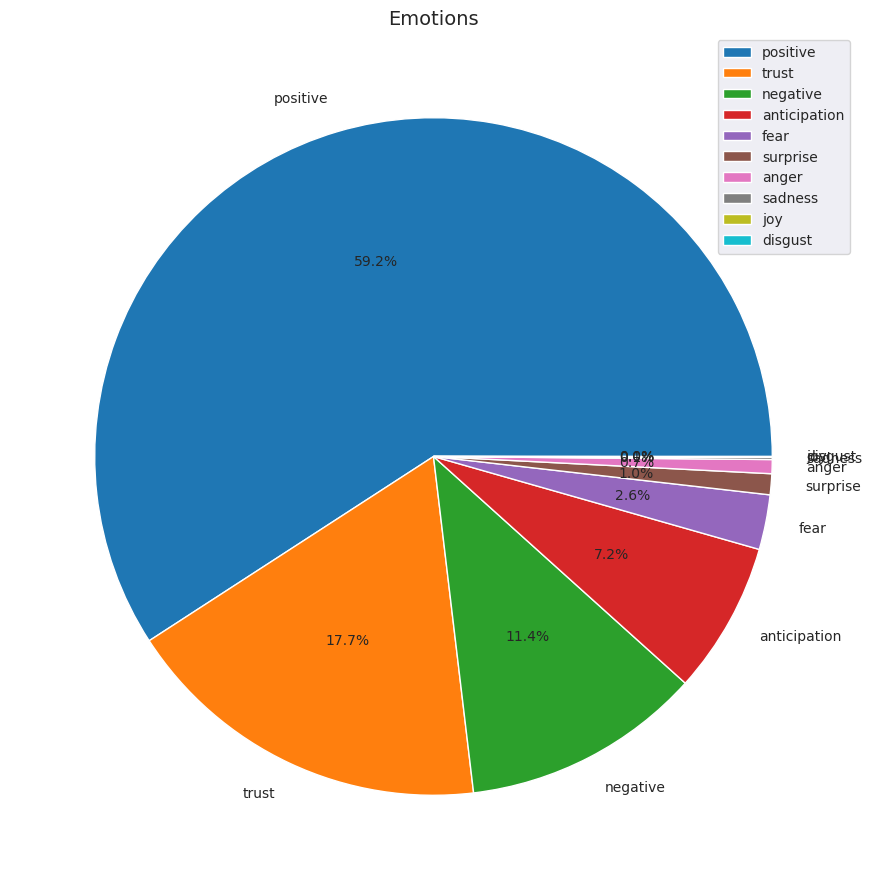

In [60]:
# A pie chart for showing the percentage of every emotion in the text
labels = emotion_chart.index.tolist()
plt.figure(figsize = (11,11))
plt.pie(emotion_chart['Emotions'].values, labels = labels , autopct = '%1.1f%%', labeldistance= 1.1)
plt.title('Emotions', fontsize = 14)
plt.legend(loc = 'upper right')
plt.show()